In [1]:
import numpy as np
from bci_plot.utils import data_util
import matplotlib.pyplot as plt
import pathlib
import argparse
import ast
import re

from plot_util import get_readme, get_target_pos_dia

In [2]:
def get_copilot_status(data_path):
    """ returns the copilot status. 1.0: no copilot, 0.0: copilot ON """
    readme = get_readme(data_path)
    copilot = float(readme['kfCopilotAlpha (1.0: no copilot)'])
    return copilot

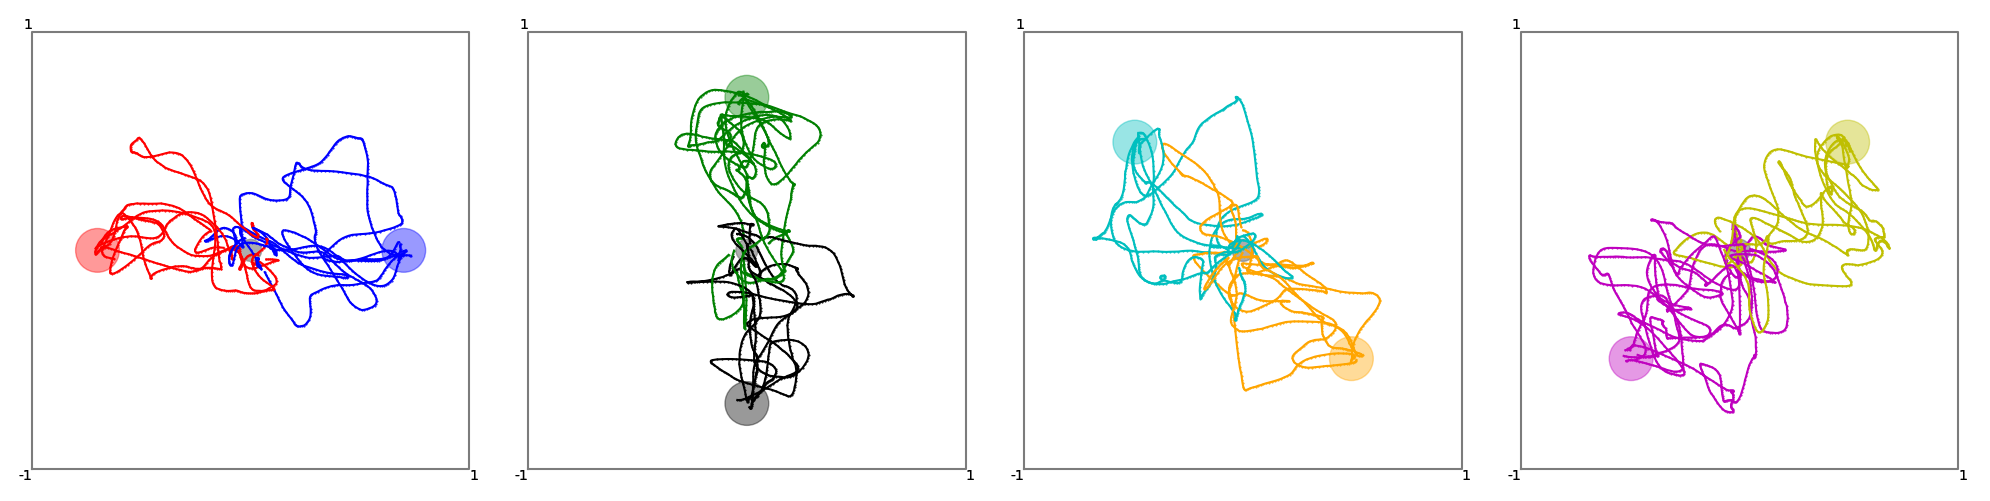

In [19]:
# session = '2024-02-14_H1_CL_CP_1' # no copilot
session = '2024-02-14_H1_CL_CP_2' # with copilot
datadir = pathlib.Path('/data/raspy/')
data_path = datadir / session

# read the target position and diameter from the readme.txt
positions, target_dia = get_target_pos_dia(data_path)

# read the task data
task_data = data_util.load_data(data_path / 'task.bin')
state_task = task_data['state_task'].flatten().copy() # tells about the game state i.e. where the target is
state_task[task_data['numCompletedBlocks'].flatten() < 0] = 99 # for the starting few calibration trials

# 4 is missing from the state_task. 0,1,2,3,5,6,7,8 left, right, up, down, lu, ld, ru, rd
colors = {0:'r', 1:'b', 2:'g', 3:'k', 5:'c', 6:'m', 7:'y', 8:'orange'}
subplot_map = {0:0, 1:0, 2:1, 3:1, 5:2, 6:3, 7:3, 8:2}
circle_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:3, 6:3, 7:2}
colors_map = {0:0, 1:1, 2:2, 3:3, 4:5, 5:6, 6:7, 7:8}

# start and end indices for trials. reading the index at which the game state changes 
start_inds = np.nonzero(state_task[1:None] != state_task[0:-1])[0][1:None] + 1
end_inds = np.hstack([start_inds[1:None], [len(state_task)+1]])

# Create single plot with 4 subplots
fig, axes = plt.subplots(1,4,figsize=(20, 10))
# Flatten the axes array to iterate over it easily
axes = axes.flatten()

for start, end in zip(start_inds, end_inds):
    xy = task_data['decoded_pos'][start:end]
    target = state_task[start]
    if target != 99:
        c = colors[target]
        ax = axes[subplot_map[target]]
        ax.plot(xy[1:, 0], xy[1:, 1], '.-', c=c, ms=1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(-1.1, 1.1)
        ax.axis('off')

for i in range(8):
    # plt.subplot(2,4,i+1)
    
    circle = plt.Circle(positions[i], target_dia/2.0, color=colors[colors_map[i]], alpha=0.4, zorder=-4)
    cursor = plt.Circle((0.0, 0.0), 0.05, color='gray', alpha=0.4, zorder=-4)
    ax = axes[circle_map[i]]
    # ax = plt.gca()
    ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k', alpha = 0.3)
    ax.add_patch(circle)
    ax.add_patch(cursor)
    ax.set_aspect('equal')
    # Annotate the end points
    ax.text(-1, -1, '-1', fontsize=10, ha='right', va='top')
    ax.text(-1, 1, '1', fontsize=10, ha='right', va='bottom')
    ax.text(1, -1, '1', fontsize=10, ha='left', va='top')

copilot_info = get_copilot_status(data_path) #kfCopilotAlpha (1.0: no copilot)
copilot = '_copilot_ON' if copilot_info == 0.0 else 'copilot_OFF'


# fig.suptitle(f'{session} {copilot} target dia {target_dia}', fontsize = 16, y= 0.75)
plt.tight_layout()
plt.savefig(f'../figs/trajectory_plots/{session}{copilot if copilot == "copilot_ON" else ""}.pdf', bbox_inches='tight')


### Plotting average trajectory

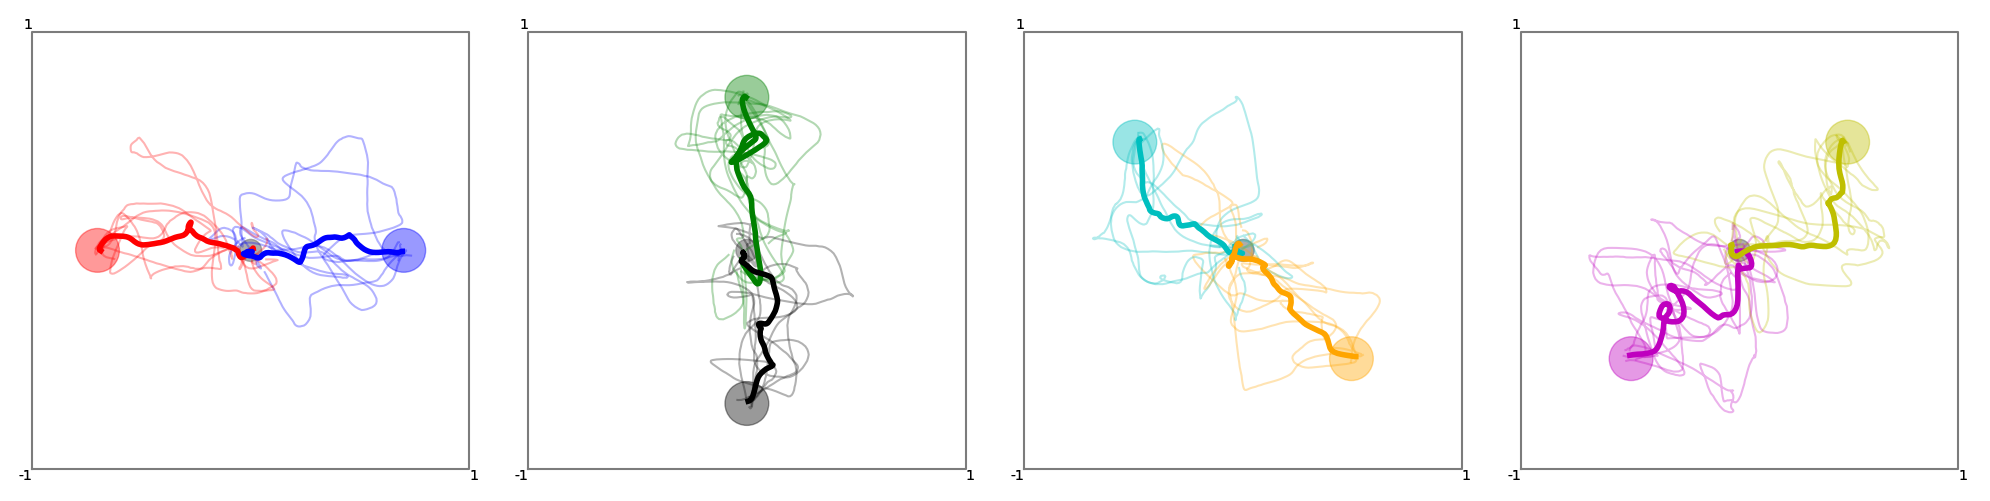

In [3]:
# session = '2024-02-14_H1_CL_CP_1' # no copilot
session = '2024-02-14_H1_CL_CP_2' # with copilot
datadir = pathlib.Path('/data/raspy/')
data_path = datadir / session

# read the target position and diameter from the readme.txt
positions, target_dia = get_target_pos_dia(data_path)

# read the task data
task_data = data_util.load_data(data_path / 'task.bin')
state_task = task_data['state_task'].flatten().copy() # tells about the game state i.e. where the target is
state_task[task_data['numCompletedBlocks'].flatten() < 0] = 99 # for the starting few calibration trials

# 4 is missing from the state_task. 0,1,2,3,5,6,7,8 left, right, up, down, lu, ld, ru, rd
colors = {0:'r', 1:'b', 2:'g', 3:'k', 5:'c', 6:'m', 7:'y', 8:'orange'}
subplot_map = {0:0, 1:0, 2:1, 3:1, 5:2, 6:3, 7:3, 8:2}
circle_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:3, 6:3, 7:2}
colors_map = {0:0, 1:1, 2:2, 3:3, 4:5, 5:6, 6:7, 7:8}

# start and end indices for trials. reading the index at which the game state changes 
start_inds = np.nonzero(state_task[1:None] != state_task[0:-1])[0][1:None] + 1
end_inds = np.hstack([start_inds[1:None], [len(state_task)+1]])

# Create single plot with 4 subplots
fig, axes = plt.subplots(1,4,figsize=(20, 10))
# Flatten the axes array to iterate over it easily
axes = axes.flatten()

# Dictionary to store trajectories for each target
trajectories = {i: [] for i in range(9) if i != 4} # Exclude 4 since it's missing 

for start, end in zip(start_inds, end_inds):
    xy = task_data['decoded_pos'][start:end]
    target = state_task[start]
    if target != 99:
        c = colors[target]
        ax = axes[subplot_map[target]]
        ax.plot(xy[1:, 0], xy[1:, 1], c=c, ms=1, alpha = 0.3)
        trajectories[target].append(xy[1:]) # Store the trajectory
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(-1.1, 1.1)
        ax.axis('off')

# Plot average trajectories
# Plot average trajectories
for target, traj_list in trajectories.items():
    if traj_list:  # Check if there are trajectories for this target
        interp_x = []
        interp_y = []
        for traj in traj_list:
            interp_x.append(np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(traj)), traj[:, 0]))
            interp_y.append(np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(traj)), traj[:, 1]))
        
        avg_traj_x = np.mean(interp_x, axis=0)
        avg_traj_y = np.mean(interp_y, axis=0)
        ax = axes[subplot_map[target]]
        c = colors[target]
        ax.plot(avg_traj_x, avg_traj_y, c=c, linewidth=4, label='Avg Trajectory')


for i in range(8):
    # plt.subplot(2,4,i+1)
    
    circle = plt.Circle(positions[i], target_dia/2.0, color=colors[colors_map[i]], alpha=0.4, zorder=-4)
    cursor = plt.Circle((0.0, 0.0), 0.05, color='gray', alpha=0.4, zorder=-4)
    ax = axes[circle_map[i]]
    # ax = plt.gca()
    ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k', alpha = 0.3)
    ax.add_patch(circle)
    ax.add_patch(cursor)
    ax.set_aspect('equal')
    # Annotate the end points
    ax.text(-1, -1, '-1', fontsize=10, ha='right', va='top')
    ax.text(-1, 1, '1', fontsize=10, ha='right', va='bottom')
    ax.text(1, -1, '1', fontsize=10, ha='left', va='top')

copilot_info = get_copilot_status(data_path) #kfCopilotAlpha (1.0: no copilot)
copilot = '_copilot_ON' if copilot_info == 0.0 else 'copilot_OFF'


# fig.suptitle(f'{session} {copilot} target dia {target_dia}', fontsize = 16, y= 0.75)
plt.tight_layout()
plt.savefig(f'../figs/trajectory_plots/{session}{copilot if copilot == "copilot_ON" else ""}_average.pdf', bbox_inches='tight')


### Plot only the average trajectory plots

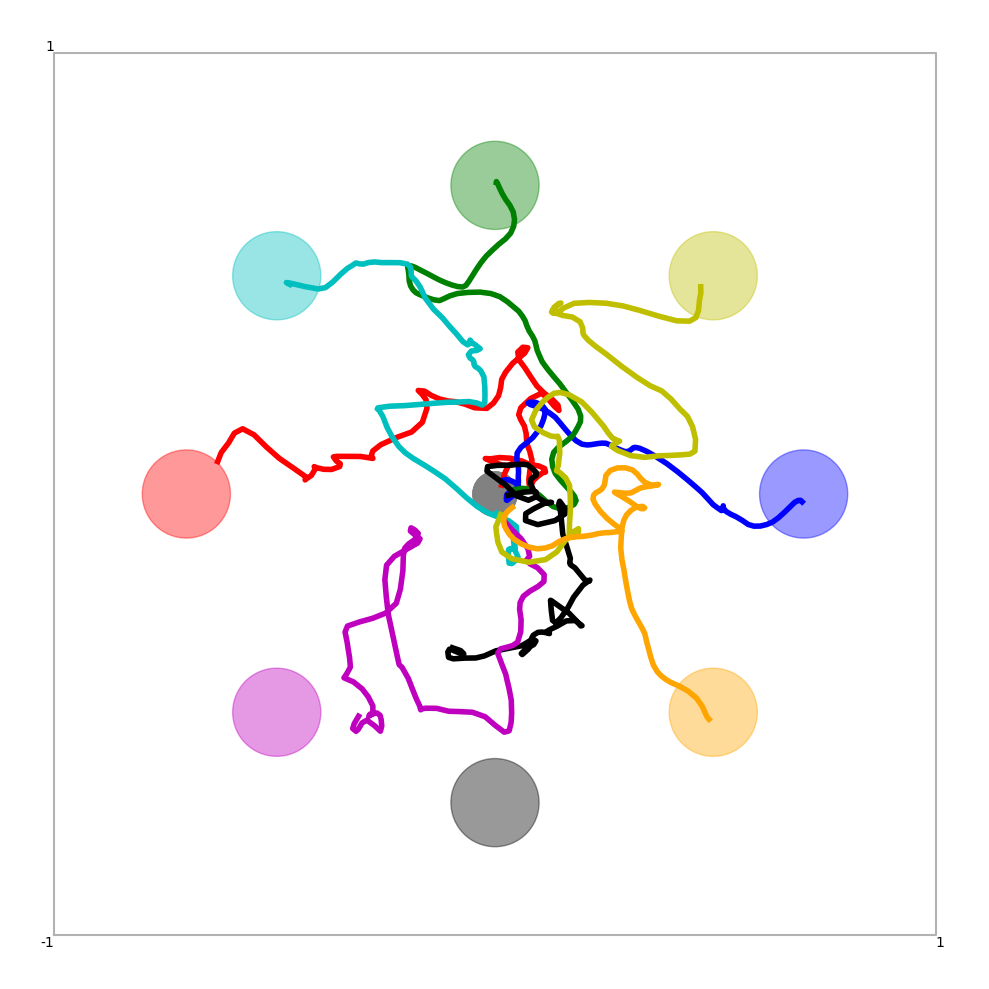

In [20]:
# H1
# session = '2024-02-14_H1_CL_CP_1' # no copilot
# session = '2024-02-14_H1_CL_CP_2' # with copilot

#S2
# session = '2024-03-18_S2_CL_3' # no copilot
session = '2024-03-18_S2_CL_4' # with copilot
datadir = pathlib.Path('/data/raspy/')
data_path = datadir / session

# read the target position and diameter from the readme.txt
positions, target_dia = get_target_pos_dia(data_path)

# read the task data
task_data = data_util.load_data(data_path / 'task.bin')
state_task = task_data['state_task'].flatten().copy() # tells about the game state i.e. where the target is
state_task[task_data['numCompletedBlocks'].flatten() < 0] = 99 # for the starting few calibration trials

# 4 is missing from the state_task. 0,1,2,3,5,6,7,8 left, right, up, down, lu, ld, ru, rd
colors = {0:'r', 1:'b', 2:'g', 3:'k', 5:'c', 6:'m', 7:'y', 8:'orange'}
subplot_map = {0:0, 1:0, 2:1, 3:1, 5:2, 6:3, 7:3, 8:2}
circle_map = {0:0, 1:0, 2:1, 3:1, 4:2, 5:3, 6:3, 7:2}
colors_map = {0:0, 1:1, 2:2, 3:3, 4:5, 5:6, 6:7, 7:8}

# start and end indices for trials. reading the index at which the game state changes 
start_inds = np.nonzero(state_task[1:None] != state_task[0:-1])[0][1:None] + 1
end_inds = np.hstack([start_inds[1:None], [len(state_task)+1]])

# Create single plot with 4 subplots
fig, ax = plt.subplots(figsize=(10, 10))
# # Flatten the axes array to iterate over it easily
# axes = axes.flatten()

# Dictionary to store trajectories for each target
trajectories = {i: [] for i in range(9) if i != 4} # Exclude 4 since it's missing 

for start, end in zip(start_inds, end_inds):
    xy = task_data['decoded_pos'][start:end]
    target = state_task[start]
    if target != 99:
        # c = colors[target]
        # ax = axes[subplot_map[target]]
        # ax.plot(xy[1:, 0], xy[1:, 1], c=c, ms=1, alpha = 0.3)
        trajectories[target].append(xy[1:]) # Store the trajectory
        # ax.set_ylim(-1.1, 1.1)
        # ax.set_xlim(-1.1, 1.1)
        # ax.axis('off')

# Plot average trajectories
# Plot average trajectories
for target, traj_list in trajectories.items():
    if traj_list:  # Check if there are trajectories for this target
        interp_x = []
        interp_y = []
        for traj in traj_list:
            interp_x.append(np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(traj)), traj[:, 0]))
            interp_y.append(np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, len(traj)), traj[:, 1]))
        
        avg_traj_x = np.mean(interp_x, axis=0)
        avg_traj_y = np.mean(interp_y, axis=0)
        # ax = axes[subplot_map[target]]
        c = colors[target]
        ax.plot(avg_traj_x, avg_traj_y, c=c, linewidth=4, label='Avg Trajectory')


for i in range(8):
    # plt.subplot(2,4,i+1)

    circle = plt.Circle(positions[i], target_dia/2.0, color=colors[colors_map[i]], alpha=0.4, zorder=-4)
    cursor = plt.Circle((0.0, 0.0), 0.05, color='gray', alpha=0.4, zorder=-4)
    # ax = axes[circle_map[i]]
    # ax = plt.gca()
    
    ax.add_patch(circle)
    ax.add_patch(cursor)
   


ax.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k', alpha = 0.3)
ax.set_aspect('equal')
ax.axis('off')

# Annotate the end points
ax.text(-1, -1, '-1', fontsize=10, ha='right', va='top')
ax.text(-1, 1, '1', fontsize=10, ha='right', va='bottom')
ax.text(1, -1, '1', fontsize=10, ha='left', va='top')

copilot_info = get_copilot_status(data_path) #kfCopilotAlpha (1.0: no copilot)
copilot = '_copilot_ON' if copilot_info == 0.0 else 'copilot_OFF'


# fig.suptitle(f'{session} {copilot} target dia {target_dia}', fontsize = 16, y= 0.75)
plt.tight_layout()
plt.savefig(f'../figs/trajectory_plots/{session}{copilot if copilot == "_copilot_ON" else ""}_Average_AllTargets.pdf', bbox_inches='tight')


In [6]:
positions

[(-0.7, 0),
 (0.7, 0),
 (0, 0.7),
 (0, -0.7),
 (-0.495, 0.495),
 (-0.495, -0.495),
 (0.495, 0.495),
 (0.495, -0.495)]

In [15]:
copilot_info

1.0